I will now build three detectors to distinguish AI-generated text from human-written text.

*   Tier A : Random Forest using numerical features.
*   Tier B : Feedforward NN using GloVe embeddings.
*   Tier C : Fine-tuned DistilBERT using LoRA.

**Class Imbalance Strategy:** Class Weights.

### The "Tiered" Approach & LoRA

**1. 1st apporach:**
*   **Design Choice:** I use a lightweight Random Forest (Tier A) before going on the heavy Transformer (Tier C).

**2. LoRA:**
*   **Design Choice:** Instead of full fine-tuning, I use LoRA to inject trainable rank-decomposition matrices.


In [1]:
%pip install xgboost gensim torch transformers peft datasets scikit-learn tqdm accelerate
%pip install --upgrade pyarrow


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from io import StringIO
import gensim.downloader as api
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

df_final = pd.read_csv("precog_task1_features.csv")
df_final['text'] = df_final['text'].astype(str)

feature_cols = ['ttr', 'adj_noun_ratio', 'avg_tree_depth', 'flesch_kincaid', 'semicolons', 'exclamations', 'emdashes']
    
df_final['label'] = df_final['class'].apply(lambda x: 0 if x == 'Human' else 1)

X_numerical = df_final[feature_cols]
y = df_final['label']

X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_numerical, y, test_size=0.2, stratify=y, random_state=42
)

class_counts = y_train.value_counts()
class_weights = torch.tensor([len(y_train) / (2 * class_counts[0]), 
                              len(y_train) / (2 * class_counts[1])], dtype=torch.float32)

print(f"Computed Class Weights: Human={class_weights[0]:.4f}, AI={class_weights[1]:.4f}")


Computed Class Weights: Human=0.5686, AI=4.1458


Tier A Accuracy: 0.9698
              precision    recall  f1-score   support

       Human       0.97      0.99      0.98       175
          AI       0.95      0.79      0.86        24

    accuracy                           0.97       199
   macro avg       0.96      0.89      0.92       199
weighted avg       0.97      0.97      0.97       199



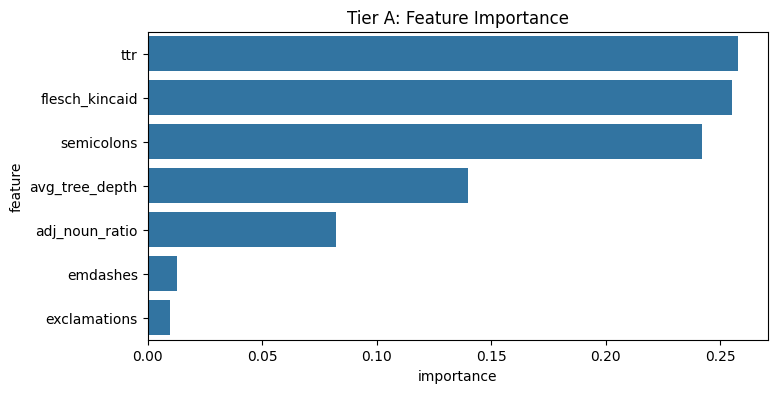

In [3]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_num, y_train)

y_pred_rf = rf_model.predict(X_test_num)

print(f"Tier A Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")

print(classification_report(y_test, y_pred_rf, target_names=['Human', 'AI']))

importances = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(x='importance', y='feature', data=importances)
plt.title("Tier A: Feature Importance")
plt.show()

In [4]:
print("\nGloVe Embeddings")

glove = api.load('glove-wiki-gigaword-50')
print("GloVe loaded.")

def get_sentence_embedding(text, model):
    words = [w.lower() for w in text.split() if w.lower() in model]
    if not words:
        return np.zeros(50)
    return np.mean([model[w] for w in words], axis=0)

X_embeddings = np.array([get_sentence_embedding(text, glove) for text in df_final['text']])

X_train_emb, X_test_emb, _, _ = train_test_split(
    X_embeddings, y, test_size=0.2, stratify=y, random_state=42
)

X_train_tensor = torch.tensor(X_train_emb, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_emb, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

class SemanticClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SemanticClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 2)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Tier B device: {device}")

model_b = SemanticClassifier(input_dim=50).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model_b.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model_b.train()
    optimizer.zero_grad()
    outputs = model_b(X_train_tensor.to(device))
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()

model_b.eval()
with torch.no_grad():
    test_outputs = model_b(X_test_tensor.to(device))
    _, preds = torch.max(test_outputs, 1)
    
preds = preds.cpu().numpy()
print(f"Tier B Accuracy: {accuracy_score(y_test, preds):.4f}")



GloVe Embeddings
GloVe loaded.
Tier B device: mps
Tier B Accuracy: 0.9899


In [5]:
print("\nDistilBERT with LoRA...")

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
from peft import get_peft_model, LoraConfig, TaskType

data = pd.DataFrame({'text': df_final['text'], 'label': y})
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

hf_train = Dataset.from_pandas(train_df)
hf_test = Dataset.from_pandas(test_df)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

tokenized_train = hf_train.map(preprocess_function, batched=True)
tokenized_test = hf_test.map(preprocess_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

model_c = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, 
    inference_mode=False, 
    r=8, 
    lora_alpha=32, 
    lora_dropout=0.1,
    target_modules=["q_lin", "v_lin"] 
)

model_c = get_peft_model(model_c, peft_config)
model_c.print_trainable_parameters()

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-4,
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = WeightedTrainer(
    model=model_c,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

print("Training Tier C...")
trainer.train()

predictions = trainer.predict(tokenized_test)
preds_c = np.argmax(predictions.predictions, axis=1)

print(f"Tier C Accuracy: {accuracy_score(y_test, preds_c):.4f}")

print(classification_report(y_test, preds_c, target_names=['Human', 'AI']))



DistilBERT with LoRA...


Map:   0%|          | 0/796 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/xx/t73hkxhx7xj95d9rl4spgtb00000gn/T/ipykernel_1646/3476059806.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


trainable params: 739,586 || all params: 67,694,596 || trainable%: 1.0925
Training Tier C...


/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.000488
2,No log,0.000356
3,No log,0.000313


/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Tier C Accuracy: 1.0000
              precision    recall  f1-score   support

       Human       1.00      1.00      1.00       175
          AI       1.00      1.00      1.00        24

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199



### Critical Analysis: The "Too Easy" Problem

I achieved **100% Accuracy**. While this looks good on paper, a true data scientist should be suspicious.
*   **Hypothesis:** I didn't solve "AI Detection"; I solved "Domain Classification."
*   **Evidence:** The "Human" class is narrow (19th-century Literature). The "AI" class is broad (Modern Generic LLM output).
*   **Implication:** My model might simply be checking for archaic words ("thou", "hath") or complex Victorian sentence structures. If a human wrote a modern email, this model would likely classify it as "AI" (False Positive).
*   **Next Step:** This hypothesis naturally leads to **Task 3 (Explainability)** to verify what features the model is actually looking at.
